# PCA (Principal Component Analysis; 主成分分析)

## PCAを考える前に... 

5人の被験者に対して、それぞれ身長と体重を測定したとします。この時、以下のような表が作られたとします。

In [1]:
import pandas as pd 
df = pd.DataFrame(
    [[160,140,180,170,165],
    [60,50,72,64,80],
    ["女","女","男","男","男"],
    ],
    columns="A子、B美、C太、D介、E吉".split("、")
).T
df.columns = ["身長","体重","性別"]
df

身長  体重 性別
A子  160  60  女
B美  140  50  女
C太  180  72  男
D介  170  64  男
E吉  165  80  男

ここでそれぞれの人間は、以下のような散布図で表すことができます。

In [2]:
import plotly.express as px 
px.scatter(df, 
           x="身長", y="体重", 
           color="性別",
           title="身長体重の空間で人間を表現する散布図",
           width=500, 
           height=500,
           )

これは非常にわかりやすい例であり、男女の傾向（どの性別の個体がグラフ中のどこに集まっているか、など）も簡単に見て取れます。しかし、データがもっと増えるにつれ、身長体重だけでは男女の判別がつけずらい個体が現れます。また、そもそも性別にはグラデーションがあったり、もっと様々な区分があったりするので、よりたくさんの特徴を集めることを考えましょう。

先ほどのデータを更に増やして、「身長、体重、性別、肌の色、宗教、手の大きさ、足の大きさ、etc...」のような特徴を1000種類も収集したとしましょう。一人の人間を表すために、1000種類もの特徴を使っていることになりますね。すると先ほどの散布図を考えると、人間は1000次元の空間の点として表現されています。1000次元の空間、どうやって可視化すればいいんでしょうか？人間は三次元までしか認識することができないので、超高次元生命体（そんなものがいれば、ですが）じゃないと視覚的に把握することは難しそうです。

また、例えば性別を「男、女、その他」として、これのクラス分類を考えましょう。膨大に集めた特徴のうち、クラス分類に不要な特徴があるはずです。また、クラス分類には有用でも、他の特徴量と似たような（相関の高い）特量があるかもしれません。複数の特徴量同士の相関が高い時、そのうちのどれか一つがあれば十分でしょう。このように特徴量は闇雲にたくさん集めても、分析の段階になってから不要になることがあります。

また、そもそも、クラス分類を行う際に特徴の数が多すぎると訓練にかかる計算コストが大きくなってしまうという課題もあります。

ここまでで示したいくつかの問題を解決するために、PCAを用いることがあります。

## PCAとは

PCA（主成分分析）とは、最も一般的な次元圧縮手法の一つです。「次元圧縮」とは、$\text{データ数} D \times \text{特徴数} F$の行列を、できるだけ情報量を減らさずにより小さい行列 $ \text{データ数} D \times \text{元の特徴量より小さい次元数} K$ に圧縮するアプローチです。

PCAで圧縮したいデータは、高次元空間にあります。そのため、既存の特徴軸よりもデータ全体の分散の大きい新しい軸を見つけることができれば、データをより分かりやすく表現できるでしょう。

情報量がだいぶ保持されたままで$F$よりかなり小さい$K$次元に変換することができれば、まず「特徴量が多すぎて機械学習モデルの訓練にかかる計算コストが高すぎる」という問題は解決できます。

また、PCAの変換によって作られた新しい特徴量は、それぞれが直交し、相関係数が0に近くなるように設計されています。これはつまり「似たような特徴量を削除する」ことに成功していると言えます。重回帰分析において、相関の大きい特徴があると起きる多重共線性の問題を解決できます。




## scikit-learnを使った実験

In [3]:
import numpy as np
import pandas as pd 
import plotly.express as px 
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import seaborn as sns

scikit-learnでは、PCAはdecompositionモジュールの下にクラスが実装されています。decompositionはさまざまな次元圧縮手法のクラスが用意されたモジュールであり、PCA以外にも、LDA（Latent Dirichlet Allocaiton; 潜在的ディリクレ配分法）やNMF（Non-Negative Matrix Factorization）などの有名な次元圧縮・行列分解アルゴリズムが実装されています。この下にあるクラスは全てほぼ同様の方法で利用することができるので、PCAを使って利用方法を習得しましょう。

まずはデモンストレーションのために、iris dataset（アヤメの花のデータセット、クラス分類によく用いられます）を読み込みます。

In [4]:
df = load_iris(as_frame=True)["frame"]
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0


データセットの各特徴が何を表しているかについては，以下の画像を参考にしてください．

> ![](./figs/setosa_versicolor_virginica.png)  
> 出典：[Iris Species Classification — Machine Learning Model](https://morioh.com/p/eafb28ccf4e3)

このデータセットの特徴量は4つあるので、2次元散布図を使って可視化する場合には次のような散布図行列を作ることになります。

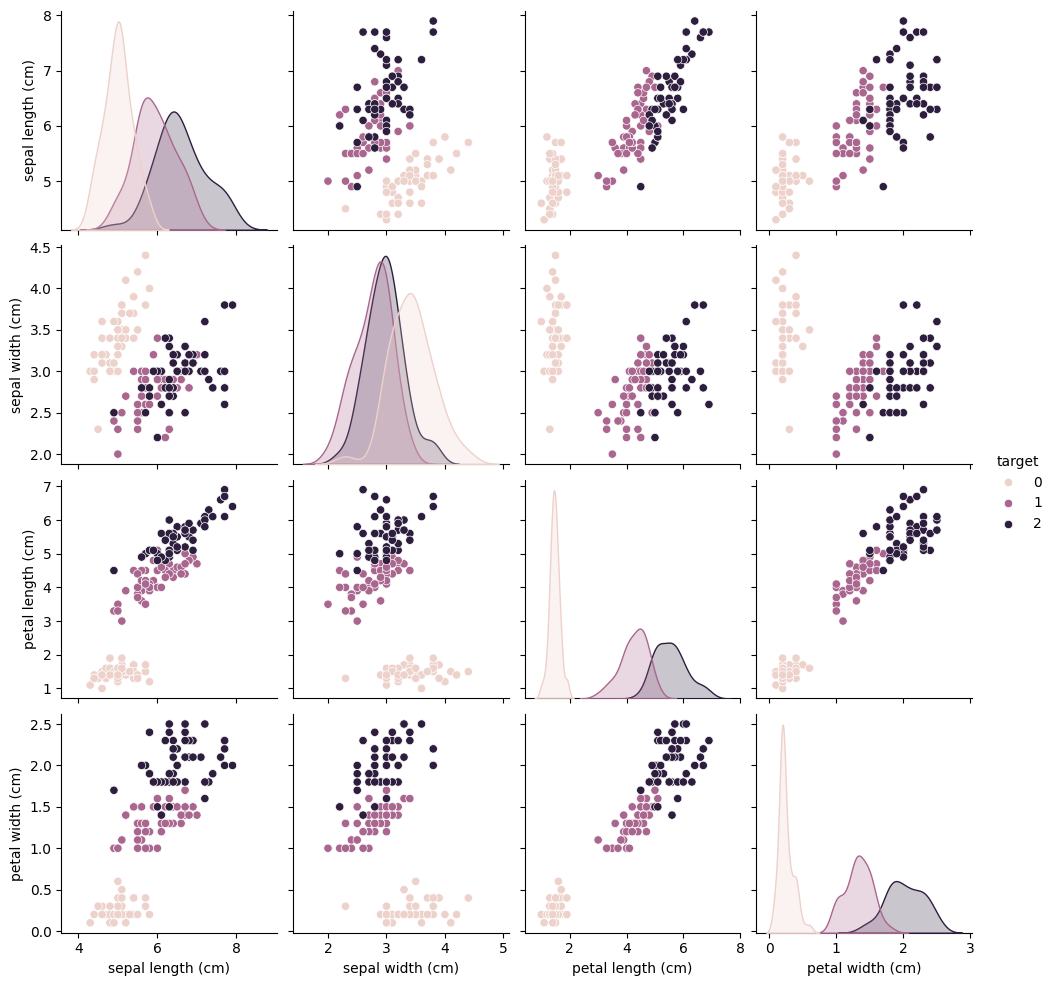

In [5]:
sns.pairplot(df, hue="target")

必要があれば`df.info()`や`df.describe()`のようなメソッドを使って、より詳細な情報を確認してみてください。大切なのは、このデータセットではクラスが3つあり、それぞれのデータが4つの数値特徴を持っている、ということです。またデータは全部で150個あります。

縦軸と横軸の入れ替えを許すならば、${}_4 C_2=6$通りの散布図が必要になります。この数は特徴量の種類が増えればそれだけ増えるので、散布図行列を使って全ての特徴量の組み合わせを可視化するのは取り回しが悪いということに気づきます。そこでPCAを使った次元圧縮の出番です。ここでは全てのデータを使って、可視化しやすいように2次元に圧縮します。

In [6]:
pca = PCA(n_components=2) # 初期化、2次元に圧縮
pca.fit(df.drop("target", axis=1)) # targetはクラスラベルなので除外
pca.transform(df.drop("target", axis=1))[:10] # 結果の確認のために先頭10行を表示

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425]])

Pythonのクラスでは、基本的に`インスタンス名 = クラス名()`とすることでクラスを初期化してインスタンスを生成できます。よく言う「クラスは設計書で、インスタンスは実際の製造品」と言うやつです。クラスはただの設計書というだけではなく、製品を作る前にいくつかの任意で決められるパラメータを持っています。

「ここで製造するロボットのプラモデルは、サイズが標準だと30cmだけど今回は18mにしよう」

みたいなことができるんですね。今回はそのパラメータとして`n_components`を指定しています。PCAを使って何次元に行列を圧縮するのかを決めているパラメータです。

また、`インスタンス名().fit(訓練させたいnp.ndarray)`とすることでこのインスタンスに実装された機械学習モデルの訓練（学習）を行います。scikit-learnではfitメソッドの返り値として、学習が終わった自分自身（return self）を返します。もちろんfitを呼び出したインスタンス自身もパラメータが訓練によって変更されているので、fitメソッドの返り値は捨ててしまって（変数に代入しなくて）も大丈夫です。

最後に`インスタンス名.transform(変換したいnp.ndarray)`とすることで、データをPCAによって変換（transform）することができます。つまり

「$\text{データ数} D \times \text{特徴数} F$の行列を、できるだけ情報量を減らさずにより小さい行列 $ \text{データ数} D \times \text{元の特徴量より小さい次元数} K$ に変換できた」

と言うことになります。

ではPCAで変換した（圧縮した）iris dataを散布図で確認してみましょう。

In [7]:
iris_transformed = pca.transform(df.drop("target", axis=1))
print(pca.explained_variance_ratio_)
df[["PC1","PC2"]] = iris_transformed
fig = px.scatter(df, 
                 x="PC1",y="PC2", 
                 color="target", 
                 height=500,width=500,
                 title="PCAを使ったiris datasetの可視化")
fig.show()

[0.92461872 0.05306648]


ここでは色がクラスを表すように指定しています。iris datasetは綺麗な（クラスごとに分離が簡単な）データセットです。PCAが新しく作成した二つの次元（これを主成分、Principal Componentと呼びます）を持った空間の上で、それぞれのデータが綺麗にクラスごとにまとまっていることが見て取れます。

## NumPyを使って実装する

ここまで私たちは、scikit-learnの中に「既に実装された」PCAを使ってデモを試してきました。次はNumPyを使ってPCAを実装してみましょう。

:::{margin}
おそらくここに疑似コードを載せるのが良いだろう... 
:::

In [8]:
import numpy as np
import pandas as pd 
import plotly.express as px 
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA 
from sklearn.exceptions import NotFittedError

In [9]:
class MyPCA:
    def __init__(self, n_components:int=2, standardization:bool=False):
        self.n_components = n_components
        self.standardization = standardization
        self.is_fitted = False
        
    def fit(self,X:np.ndarray,y=None)->"MyPCA":
        X = np.asarray(X)
        self.mu_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        if self.standardization:
            # 特徴毎に標準化
            X_hat = (X - self.mu_) / self.std_
        else:
            # 特徴毎にセンタリング
            X_hat = X - self.mu_
        # shifted_Xの分散共分散行列を作成する
        self.cov_ = np.cov(X_hat, rowvar=False)
        # 固有値と固有ベクトルを求めて固有値の大きい順にソート
        eigenvalues, eigenvectors = np.linalg.eig(self.cov_)
        sorted_eigenvalues_indices = np.argsort(eigenvalues)[::-1]
        # 固有値の大きい順に固有値と固有ベクトルを一応保存しておく
        self.eigenvalues_ = eigenvalues[sorted_eigenvalues_indices]
        self.eigenvectors_ = eigenvectors[sorted_eigenvalues_indices]
        # 寄与率
        self.explained_variance_ratio_ = self.eigenvalues_ / self.eigenvalues_.sum()
        self.explained_variance_ratio_ = self.explained_variance_ratio_[:self.n_components]
        # 累積寄与率
        self.cumulative_proportion_ = self.explained_variance_ratio_.sum()
        # 固有値の大きい順にself.n_components個の固有ベクトルを集める
        self.components_ = self.eigenvectors_[:,:self.n_components].T
        self.is_fitted = True
        return self

    def transform(self, X:np.ndarray)->np.ndarray:
        if not self.is_fitted:
            raise NotFittedError(f"{self.__class__.__name__}.transformはfit後にのみ利用できる")
        if self.components_.shape[1] != X.shape[1]:
            raise ValueError("Xと訓練データの特徴数が異なっている")
        X = np.asarray(X)
        if self.standardization:
            # 特徴毎に標準化
            X_hat = (X - self.mu_) / self.std_
        else:
            # 特徴毎にセンタリング
            X_hat = X - self.mu_
        return X_hat @ self.components_.T

In [10]:
df = load_iris(as_frame=True)["frame"]
df.head()

pca = MyPCA(n_components=2)
pca.fit(df.drop("target", axis=1))
iris_transformed = pca.transform(df.drop("target", axis=1))

df[["PC1","PC2"]] = iris_transformed
fig = px.scatter(df, 
                 x="PC1",y="PC2", 
                 color="target", 
                 height=800,width=800,
                 title="PCAを使ったiris datasetの可視化")
#fig.show()
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

## 発展的課題

n_componentsに次元数ではなく累積寄与率を指定した際に、適切な次元数（指定された累積寄与率を超える主成分の最小数）を求めてからpcaの訓練を行えるようにMyPCAクラスを修正してみてください。

In [11]:
class MyPCA2:
    def __init__(self, n_components:int=2, standardization:bool=False):
        self.n_components = n_components
        self.standardization = standardization
        self.is_fitted = False
        
    def fit(self,X:np.ndarray,y=None)->"MyPCA":
        X = np.asarray(X)
        self.mu_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        if self.standardization:
            # 特徴毎に標準化
            X_hat = (X - self.mu_) / self.std_
        else:
            # 特徴毎にセンタリング
            X_hat = X - self.mu_
        # shifted_Xの分散共分散行列を作成する
        self.cov_ = np.cov(X_hat, rowvar=False)
        # 固有値と固有ベクトルを求めて固有値の大きい順にソート
        eigenvalues, eigenvectors = np.linalg.eig(self.cov_)
        sorted_eigenvalues_indices = np.argsort(eigenvalues)[::-1]
        # 固有値の大きい順に固有値と固有ベクトルを一応保存しておく
        self.eigenvalues_ = eigenvalues[sorted_eigenvalues_indices]
        self.eigenvectors_ = eigenvectors[sorted_eigenvalues_indices]
        # 寄与率
        self.explained_variance_ratio_ = self.eigenvalues_ / self.eigenvalues_.sum()
        if self.n_components < 1.0:
            _scan_cumulative_proportion = np.cumsum(self.explained_variance_ratio_)
            self.n_components = np.argmax(_scan_cumulative_proportion >= self.n_components) +1
        
        self.explained_variance_ratio_ = self.explained_variance_ratio_[:self.n_components]
        

        # 累積寄与率
        self.cumulative_proportion_ = self.explained_variance_ratio_.sum()
        # 固有値の大きい順にself.n_components個の固有ベクトルを集める
        self.components_ = self.eigenvectors_[:,:self.n_components].T
        self.is_fitted = True
        return self

    def transform(self, X:np.ndarray)->np.ndarray:
        if not self.is_fitted:
            raise NotFittedError(f"{self.__class__.__name__}.transformはfit後にのみ利用できます。")
        X = np.asarray(X)
        if self.standardization:
            # 特徴毎に標準化
            X_hat = (X - self.mu_) / self.std_
        else:
            # 特徴毎にセンタリング
            X_hat = X - self.mu_
        return X_hat @ self.components_.T

In [12]:
df = load_iris(as_frame=True)["frame"]
df.head()

pca = MyPCA2(n_components=0.93)
pca.fit(df.drop("target", axis=1))
iris_transformed = pca.transform(df.drop("target", axis=1))
#fig.show()
pca.explained_variance_ratio_

array([0.92461872, 0.05306648])

- 主成分分析(Principal Component Analysis, PCA)の前に変数の標準化(オートスケーリング)をしたほうがよいのか？ https://datachemeng.com/autoscaling_before_pca/
- 主成分分析で標準偏差で割るべき？に対する議論 https://qiita.com/koshian2/items/2e69cb4981ae8fbd3bda
- sklearn.exceptions.NotFittedError https://scikit-learn.org/stable/modules/generated/sklearn.exceptions.NotFittedError.html